In [1]:
from collections import defaultdict
import random
import numpy as np
import matplotlib.pyplot as plt

import time
from tqdm import tqdm 
import multiprocessing

# import gymnasium as gym
import gym
import gym_examples
from gym.wrappers import FlattenObservation

from algos import *
from utils import *

In [6]:

random.seed(123)
np.random.seed(123)
tdqm_disable = True

# params
env_id = "gym_examples/GridWorld-v3"
gridworld_size = 3
max_steps = 20
gamma = 0.95

num_trials = 1000
num_episodes_train = 10000
num_episodes_eval = 100

lr_sched_type = "poly"
lr_sched_fn = create_lr_sched_fn(lr_sched_type)

max_eps = 1.0
min_eps = 0.05
decay_rate = 0.0005
eps_sched_type = "poly"
eps_sched_fn = create_eps_sched_fn(eps_sched_type, min_eps, max_eps, decay_rate)

haver_const = 10.0
est_name = "haver" 
q_algo_name = "haver_q_learning"
q_algo = create_q_algo(q_algo_name)

# create gym env
env = gym.make(env_id, size=gridworld_size)
env_wrapped = FlattenObservation(env)
num_actions = env_wrapped.action_space.n
# print(f"num_actions = {num_actions}")
# print(env_wrapped.reset())
# stop

manager = multiprocessing.Manager()
episode_lengths_list = manager.list()
episode_rewards_list = manager.list()
episode_start_vals_list = manager.list()

def run_trial(i_trial, args):

    random.seed(10000+i_trial)
    np.random.seed(10000+i_trial)

    env = gym.make(env_id, size=gridworld_size)
    env_wrapped = FlattenObservation(env)
    # env_wrapped.reset(seed=10000+i_trial)

    lr_sched_fn = create_lr_sched_fn(lr_sched_type)
    eps_sched_fn = create_eps_sched_fn(eps_sched_type, min_eps, max_eps, decay_rate)
    q_algo = create_q_algo(args["algo_name"])

    # init Q_table, Q_nvisits
    Q_table = defaultdict(lambda: np.zeros(num_actions))
    Q_nvisits = defaultdict(lambda: np.zeros(num_actions))
    Q_table, stats = q_algo(
        env_wrapped, Q_table, Q_nvisits, num_episodes_train, max_steps,
        gamma, lr_sched_fn, eps_sched_fn, tdqm_disable, args)

    episode_lengths, episode_rewards, episode_start_vals= zip(*stats)
    episode_lengths_list.append(episode_lengths)
    episode_rewards_list.append(episode_rewards)
    episode_start_vals_list.append(episode_start_vals)

episode_lengths_mean_dict = defaultdict()
episode_rewards_mean_dict = defaultdict()
episode_start_vals_mean_dict = defaultdict()

args = dict()
pool = multiprocessing.Pool()

# algo_names = ["haver", "double", "max", "avg"]
algo_names = ["max"]
for algo_name in algo_names:
    start_time = time.time()
    print(f"\n-> algo_name = {algo_name}")
    args["algo_name"] = algo_name
    if algo_name == "haver":
        print(f"haver_const = {haver_const}")
        args["haver_const"] =  haver_const
         
    pool.starmap(run_trial, [(i, args) for i in range(num_trials)])

    episode_lengths_ary = np.hstack([episode_lengths_list])
    episode_rewards_ary = np.hstack([episode_rewards_list])
    episode_start_vals_ary = np.hstack([episode_start_vals_list])

    episode_lengths_mean_dict[algo_name] = np.mean(episode_lengths_ary, 0)
    episode_rewards_mean_dict[algo_name] = np.mean(episode_rewards_ary, 0)
    episode_start_vals_mean_dict[algo_name] = np.mean(episode_start_vals_ary, 0)
    print(f"last_episode_length = {episode_lengths_mean_dict[algo_name][-1]}")
    print(f"last_episode_reward_per_step = {episode_rewards_mean_dict[algo_name][-1]:.4f}")
    print(f"last_episode_estim_start_val = {episode_start_vals_mean_dict[algo_name][-1]:.4f}")
    
    episode_lengths_list[:] = []
    episode_rewards_list[:] = []
    episode_start_vals_list[:] = []
    
    end_time = time.time()
    print(f"it takes {end_time-start_time:0.4f}")


-> algo_name = max
last_episode_length = 9999.0
last_episode_reward_per_step = 0.1490
last_episode_estim_start_val = 7.4266
it takes 150.8150


In [3]:
# for i_trial in range(num_trials):
#     last_episode_length = episode_lengths_list[i_trial,-1]
#     if episode_lengths_list[i_trial,-1] > 4:
#         print(i_trial, last_episode_length)
print(episode_lengths_ary[:100,-1])

[4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999
 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999
 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999
 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999
 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999
 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999
 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999 4999
 4999 4999]


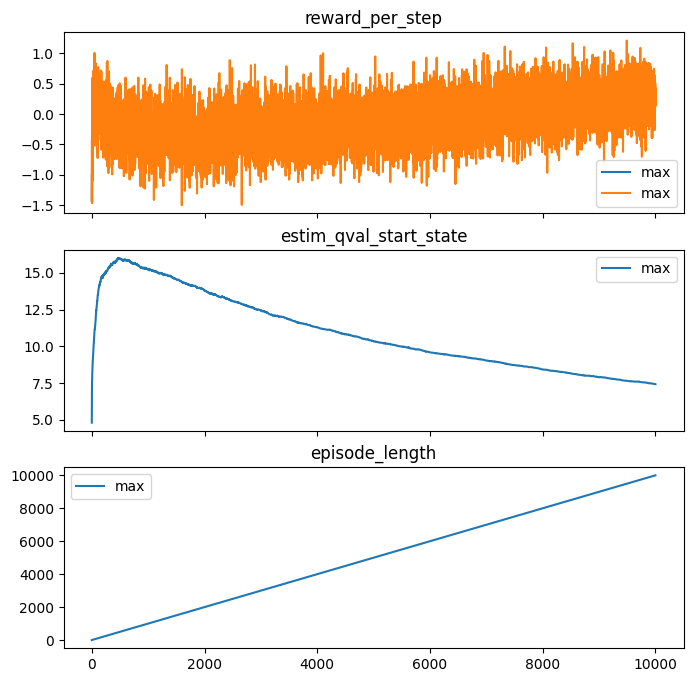

In [11]:

fig, axes = fig, axes = plt.subplots(
        nrows=3, ncols=1, sharex=True, sharey=False, figsize=(8,8))
# axes = [axes]

x_ary = np.linspace(0, num_episodes_train-1, num=10000, dtype=np.int32)
algo_names = ["haver", "double", "avg", "max"]
algo_names = ["max"]
for algo_name in algo_names:
    y_ary = running_avg(episode_rewards_mean_dict[algo_name][x_ary], 10)
    axes[0].plot(
        x_ary, y_ary, label=algo_name)
    axes[0].plot(x_ary, episode_rewards_mean_dict[algo_name][x_ary], label=algo_name)
    axes[1].plot(x_ary, episode_start_vals_mean_dict[algo_name][x_ary], label=algo_name)
    axes[2].plot(x_ary, episode_lengths_mean_dict[algo_name][x_ary], label=algo_name)

axes[0].set_title("reward_per_step")
axes[1].set_title("estim_qval_start_state")
axes[2].set_title("episode_length")
axes[0].legend()
axes[1].legend()
axes[2].legend()
plt.show()